<a href="https://colab.research.google.com/github/RealThanosP/pred-main-mod/blob/main/Model_training_v0.1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Clone repository from github

Τα πρώτα ειναι copy paste απο τον κώδικα του θανου

In [1]:
# Load the data on the server session
!git clone https://github.com/RealThanosP/pred-main-mod

# Change your working directory inside the repository
%cd pred-main-mod

Cloning into 'pred-main-mod'...
remote: Enumerating objects: 189, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 189 (delta 14), reused 3 (delta 3), pack-reused 168 (from 4)
Receiving objects: 100% (189/189), 96.41 MiB | 4.08 MiB/s, done.
Resolving deltas: 100% (108/108), done.
Updating files: 100% (29/29), done.
/content/pred-main-mod


# Review dataset

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
import os
import seaborn as sns

###Getting the sensor files in a list

In [3]:
folder_path = "data/condition+monitoring+of+hydraulic+systems"

# Define the list of sensors and their corresponding column names
sensors = [
    "PS1", "PS2", "PS3", "PS4", "PS5", "PS6",  # Pressure sensors
    "EPS1",  # Motor power
    "FS1", "FS2",  # Volume flow
    "TS1", "TS2", "TS3", "TS4",  # Temperature sensors
    "VS1",  # Vibration
    "CE",  # Cooling efficiency
    "CP",  # Cooling power
    "SE"  # Efficiency factor
]

In [4]:
# Gets all the text files from dataset
txt_files = [f for f in os.listdir(folder_path) if f.endswith('.txt')]

# Keeps only the data that have a sensor name in the filename
sensor_file_path_list = [f"{folder_path}/{f}" for f in txt_files if any(sensor in f for sensor in sensors)]
sensor_file_path_list.sort()

###Loading Data

Based on the description the classification for the data is:

The target condition values are cycle-wise annotated in �profile.txt� (tab-delimited). As before, the row number represents the cycle number. The columns are

1: Cooler condition / %: 3: close to total failure 20: reduced effifiency 100: full efficiency

2: Valve condition / %: 100: optimal switching behavior 90: small lag 80: severe lag 73: close to total failure

3: Internal pump leakage: 0: no leakage 1: weak leakage 2: severe leakage

4: Hydraulic accumulator / bar: 130: optimal pressure 115: slightly reduced pressure 100: severely reduced pressure 90: close to total failure

5: stable flag: 0: conditions were stable 1: static conditions might not have been reached yet

In [5]:
# profile
profile = pd.read_csv("data/condition+monitoring+of+hydraulic+systems/profile.txt", sep="\t", header=None)
profile.columns = ["cooler_condition", "valve_condition", "internal_pump_leakage", "hydraulic_accumulator", "stable_flag"]
profile

,cooler_condition,valve_condition,internal_pump_leakage,hydraulic_accumulator,stable_flag
0,3,100,0,130,1
1,3,100,0,130,1
2,3,100,0,130,1
3,3,100,0,130,1
4,3,100,0,130,1
...,...,...,...,...,...
2200,100,100,0,90,0
2201,100,100,0,90,0
2202,100,100,0,90,0
2203,100,100,0,90,0


#Data preperation

Θα δοκιμασω να κανω ολα τα αρχεια των αισθητηρων να περιεχουν πληροφορειες mean, rms, max, min κλπ, να τα κάνω ένα ενιαίο dataset (και το profile μεσα) και να βαλω ως target column το stable flag.

In [6]:
# load all the files as seperate DataFrames with the file name as name
sensor_dfs = {}
for file_path in sensor_file_path_list:
    # remove the .txt
    file_name = os.path.splitext(os.path.basename(file_path))[0]

    # read the file and save it with the right name
    sensor_dfs[file_name] = pd.read_csv(file_path, sep="\t", header=None)

### Feature engineering (statistical)

In [7]:
# function that does the feature engineering
def create_stats(sensor_name, df):
    # We get the DataFrame dynamically from the name
    # Calculate statistics
    stats = pd.DataFrame({
        'mean'+ sensor_name: df.mean(axis=1),
        'std'+ sensor_name: df.std(axis=1),
        'min'+ sensor_name: df.min(axis=1),
        'max'+ sensor_name: df.max(axis=1),
        'range'+ sensor_name: df.max(axis=1) - df.min(axis=1),
        'rms'+ sensor_name: (df.pow(2).mean(axis=1)).pow(0.5)
    })
    stat_names = [f'mean{sensor_name}', f'std{sensor_name}', f'min{sensor_name}', f'max{sensor_name}', f'range{sensor_name}', f'rms{sensor_name}']
    return stats

In [8]:
# dictionary to save the names as keys and the dataframes as values
stats_dfs = {}

for sensor in sensors:
    stats_dfs[f'{sensor}_stats'] = create_stats(sensor, sensor_dfs[sensor])

# Converts the keys of the dictionary to variables
globals().update(stats_dfs)

In [9]:
PS1_stats

,meanPS1,stdPS1,minPS1,maxPS1,rangePS1,rmsPS1
0,160.673492,13.939309,145.83,191.51,45.68,161.276914
1,160.603320,14.118967,145.73,191.47,45.74,161.222636
2,160.347720,14.192619,145.37,191.41,46.04,160.974495
3,160.188088,14.227803,145.14,191.34,46.20,160.818594
4,160.000472,14.276434,144.95,191.41,46.46,160.636028
...,...,...,...,...,...,...
2200,161.227572,13.987129,146.69,191.81,45.12,161.833053
2201,161.206070,14.001418,146.64,191.81,45.17,161.812867
2202,161.192120,13.988350,146.63,191.84,45.21,161.797840
2203,161.208917,13.985248,146.65,191.77,45.12,161.814305


### Combine the data by category

In [10]:
# Have all the data of the same sensor-typ in different lists
ps_stats = [PS1_stats, PS2_stats, PS3_stats, PS4_stats, PS5_stats, PS6_stats]
fs_stats = [FS1_stats, FS2_stats]
ts_stats = [TS1_stats, TS2_stats, TS3_stats, TS4_stats]

In [11]:
stat_names = ["mean", "std", "min", "max", "range", "rms"]

In [12]:
def combine_sensor_stats(df_list: list[pd.DataFrame], prefix: str, stat_names: list[str]) -> pd.DataFrame:
    """
    Adds corresponding statistical features (column-wise and row-wise) from multiple DataFrames.

    Parameters:
    - df_list (list[pd.DataFrame]): List of pandas DataFrames with the same shape, columns, and index.
    - prefix (str): Prefix to apply to each statistical feature (e.g., 'PS').
    - stat_names (list[str]): List of statistical feature names (e.g., ['mean', 'std', 'min', 'max', 'range', 'rms']).

    Returns:
    - pd.DataFrame: A new DataFrame with summed columns for each statistical feature, with prefixed column names.
    """
    # Initialize individual stat containers
    mean_df, std_df, min_df, max_df, range_df, rms_df = [pd.DataFrame() for _ in range(6)]

    for df in df_list:
        # Rename columns according to the prefix
        df.columns = [f"{stat}{prefix}" for stat in stat_names]

        # Extract individual columns
        mean = df[f"mean{prefix}"]
        std = df[f"std{prefix}"]
        min_ = df[f"min{prefix}"]
        max_ = df[f"max{prefix}"]
        range_stat = df[f"range{prefix}"]
        rms = df[f"rms{prefix}"]

        # Accumulate sums
        mean_df = pd.concat([mean_df, mean], axis=1).sum(axis=1)
        std_df = pd.concat([std_df, std], axis=1).sum(axis=1)
        min_df = pd.concat([min_df, min_], axis=1).sum(axis=1)
        max_df = pd.concat([max_df, max_], axis=1).sum(axis=1)
        range_df = pd.concat([range_df, range_stat], axis=1).sum(axis=1)
        rms_df = pd.concat([rms_df, rms], axis=1).sum(axis=1)

    # Combine all the summed stats into a final DataFrame
    summed_df = pd.concat([mean_df, std_df, min_df, max_df, range_df, rms_df], axis=1)
    summed_df.columns = [f"{stat}{prefix}" for stat in stat_names]

    return summed_df

In [13]:
combined_stats_ps = combine_sensor_stats(ps_stats, "PS", stat_names)
combined_stats_fs = combine_sensor_stats(fs_stats, "FS", stat_names)
combined_stats_ts = combine_sensor_stats(ts_stats, "TS", stat_names)

In [14]:
# Remake the sensors list
sensors_for_statistics = [
    "PS",  # Pressure sensors
    "EPS1",  # Motor power
    "FS",  # Volume flow
    "TS",  # Temperature sensors
    "VS1",  # Vibration
    "CE",  # Cooling efficiency
    "CP",  # Cooling power
    "SE"  # Efficiency factor
]

###Feature Engineering (frequency)

In [15]:
from scipy.fft import rfft, rfftfreq

def fft_analysis(data, sampling_rate_hz):
    """
    Perform FFT analysis on each row of raw sensor data.

    Parameters:
    - data (np.ndarray or pd.DataFrame): shape (2205, N), raw time-domain signals.
    - sampling_rate_hz (int): Sampling rate in Hz.

    Returns:
    - pd.DataFrame: DataFrame of FFT magnitudes with frequency bin labels as columns.
    """
    if isinstance(data, pd.DataFrame):
        data = data.values

    num_instances, num_samples = data.shape

    # Frequency bins: same for all rows
    freqs = rfftfreq(num_samples, d=1/sampling_rate_hz)

    # Apply FFT row-wise, get magnitude spectrum
    fft_magnitudes = np.abs(rfft(data, axis=1))

    # Convert to DataFrame with frequency labels
    fft_df = pd.DataFrame(fft_magnitudes, columns=[f"{round(f, 2)}Hz" for f in freqs])

    return fft_df

In [16]:
# Plotting fft analysis
def plot_fft_spectrum(fft_df, instance_indices=[0], max_freq=None):
    """
    Plot FFT spectrum for selected instance(s).

    Parameters:
    - fft_df (pd.DataFrame): DataFrame of FFT magnitudes (rows = instances, columns = frequency bins).
    - instance_indices (list): which instance(s) to plot from the dataset.
    - max_freq (float): maximum frequency to show (e.g., 200 Hz).
    """
    # Extract frequency values from column names
    freqs = [float(col.replace('freq_', '').replace('Hz', '')) for col in fft_df.columns]

    plt.figure(figsize=(12, 6))

    for idx in instance_indices:
        plt.plot(freqs, fft_df.iloc[idx], label=f'Instance {idx}')

    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude")
    plt.title("FFT Spectrum")
    if max_freq:
        plt.xlim(0, max_freq)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


Applying fft analysis on to all the dataframes

In [17]:
# Creating a dictionary with keys the name and as values a tuple (df, sampling_rate)
sampling_rates_dict = {
    'PS1': 100, 'PS2': 100, 'PS3': 100, 'PS4': 100, 'PS5': 100, 'PS6': 100,
    'EPS1': 100, 'FS1': 10, 'FS2': 10,
    'TS1': 1, 'TS2': 1, 'TS3': 1, 'TS4': 1,
    'VS1': 1,
    'CE': 1, 'CP': 1, 'SE': 1
}

fft_dfs = {}

for sensor in sensors:
    fft_dfs[sensor] = (fft_analysis(sensor_dfs[sensor], sampling_rates_dict[sensor]), sampling_rates_dict[sensor])

###Compine all the data

In [18]:
combined_data = pd.concat([combined_stats_ps, combined_stats_fs, combined_stats_ts, CE_stats, CP_stats, EPS1_stats, VS1_stats, SE_stats], axis=1)
combined_data

,meanPS,stdPS,minPS,maxPS,rangePS,rmsPS,meanFS,stdFS,minFS,maxFS,...,minVS1,maxVS1,rangeVS1,rmsVS1,meanSE,stdSE,minSE,maxSE,rangeSE,rmsSE
0,291.702147,62.173041,165.079,378.442,213.363,302.226405,17.014407,3.107199,10.148,29.156,...,0.532,0.624,0.092,0.577575,59.157183,23.763984,0.0,79.568,79.568,63.677996
1,291.099075,62.181253,164.741,378.404,213.663,301.620368,17.118413,3.025410,10.352,29.165,...,0.524,0.626,0.102,0.566494,59.335617,23.857918,0.0,80.441,80.441,63.878236
2,290.437285,62.200027,164.173,378.470,214.297,300.961880,17.084772,3.040609,10.296,29.141,...,0.529,0.662,0.133,0.577683,59.543150,23.923381,0.0,80.824,80.824,64.095055
3,289.975727,62.210002,163.760,377.043,213.283,300.502962,17.023243,3.046925,10.241,29.278,...,0.527,0.645,0.118,0.570233,59.794900,24.023005,0.0,80.930,80.930,64.365491
4,289.474011,62.140087,163.435,379.427,215.992,299.978761,16.928058,3.040721,10.179,29.188,...,0.524,0.660,0.136,0.578321,59.455267,23.972262,0.0,81.100,81.100,64.031400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2200,303.033461,62.239275,176.520,398.942,222.422,313.581549,16.874445,3.015213,10.147,30.452,...,0.512,0.618,0.106,0.551627,59.033100,23.635352,0.0,77.752,77.752,63.515559
2201,303.001287,62.247484,176.445,398.641,222.196,313.547839,16.869948,3.020499,10.133,30.541,...,0.507,0.584,0.077,0.547897,59.068000,23.638396,0.0,77.592,77.592,63.549111
2202,302.945512,62.230947,176.421,398.842,222.421,313.492210,16.869448,3.006082,10.127,30.296,...,0.502,0.597,0.095,0.545755,59.132350,23.633405,0.0,77.773,77.773,63.607104
2203,303.023387,62.230756,176.431,398.938,222.507,313.565487,16.862482,3.018602,10.129,30.510,...,0.502,0.585,0.083,0.537302,58.970800,23.600817,0.0,77.568,77.568,63.445019


In [19]:
# the dataset for scaling
profile_without_first_and_last_columns = profile.iloc[:, :-1]
data_for_scalling = pd.concat([combined_data, profile_without_first_and_last_columns], axis=1)
data_for_scalling

,meanPS,stdPS,minPS,maxPS,rangePS,rmsPS,meanFS,stdFS,minFS,maxFS,...,meanSE,stdSE,minSE,maxSE,rangeSE,rmsSE,cooler_condition,valve_condition,internal_pump_leakage,hydraulic_accumulator
0,291.702147,62.173041,165.079,378.442,213.363,302.226405,17.014407,3.107199,10.148,29.156,...,59.157183,23.763984,0.0,79.568,79.568,63.677996,3,100,0,130
1,291.099075,62.181253,164.741,378.404,213.663,301.620368,17.118413,3.025410,10.352,29.165,...,59.335617,23.857918,0.0,80.441,80.441,63.878236,3,100,0,130
2,290.437285,62.200027,164.173,378.470,214.297,300.961880,17.084772,3.040609,10.296,29.141,...,59.543150,23.923381,0.0,80.824,80.824,64.095055,3,100,0,130
3,289.975727,62.210002,163.760,377.043,213.283,300.502962,17.023243,3.046925,10.241,29.278,...,59.794900,24.023005,0.0,80.930,80.930,64.365491,3,100,0,130
4,289.474011,62.140087,163.435,379.427,215.992,299.978761,16.928058,3.040721,10.179,29.188,...,59.455267,23.972262,0.0,81.100,81.100,64.031400,3,100,0,130
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2200,303.033461,62.239275,176.520,398.942,222.422,313.581549,16.874445,3.015213,10.147,30.452,...,59.033100,23.635352,0.0,77.752,77.752,63.515559,100,100,0,90
2201,303.001287,62.247484,176.445,398.641,222.196,313.547839,16.869948,3.020499,10.133,30.541,...,59.068000,23.638396,0.0,77.592,77.592,63.549111,100,100,0,90
2202,302.945512,62.230947,176.421,398.842,222.421,313.492210,16.869448,3.006082,10.127,30.296,...,59.132350,23.633405,0.0,77.773,77.773,63.607104,100,100,0,90
2203,303.023387,62.230756,176.431,398.938,222.507,313.565487,16.862482,3.018602,10.129,30.510,...,58.970800,23.600817,0.0,77.568,77.568,63.445019,100,100,0,90


### Scaling the data

εδω καλο θα ηταν να ονοματησω σωστα τισ στηλες του Dataframe
**FIX το εκανε ο Θάνος :) **

In [20]:
from sklearn.preprocessing import MinMaxScaler
scaler = StandardScaler()

scaled_data = scaler.fit_transform(data_for_scalling)
scaled_data_dtset = pd.DataFrame(scaled_data, columns=data_for_scalling.columns) # Just a columns argument needed
scaled_data_dtset

,meanPS,stdPS,minPS,maxPS,rangePS,rmsPS,meanFS,stdFS,minFS,maxFS,...,meanSE,stdSE,minSE,maxSE,rangeSE,rmsSE,cooler_condition,valve_condition,internal_pump_leakage,hydraulic_accumulator
0,-0.070639,-0.360957,0.144353,-1.897972,-4.929704,-0.103511,0.875728,0.261479,1.206382,-1.516235,...,0.431929,-0.202694,0.0,-0.063981,-0.063981,0.456140,-0.902469,0.87141,-0.819277,1.387554
1,-0.126748,-0.359408,0.096028,-1.904578,-4.805717,-0.155573,0.953815,-0.166577,1.653169,-1.496113,...,0.451847,-0.153763,0.0,0.091880,0.091880,0.485438,-0.902469,0.87141,-0.819277,1.387554
2,-0.188319,-0.355868,0.014818,-1.893104,-4.543691,-0.212142,0.928557,-0.087029,1.530521,-1.549772,...,0.475014,-0.119662,0.0,0.160258,0.160258,0.517161,-0.902469,0.87141,-0.819277,1.387554
3,-0.231262,-0.353987,-0.044231,-2.141165,-4.962767,-0.251566,0.882362,-0.053975,1.410064,-1.243469,...,0.503117,-0.067767,0.0,0.179183,0.179183,0.556728,-0.902469,0.87141,-0.819277,1.387554
4,-0.277941,-0.367171,-0.090698,-1.726746,-3.843164,-0.296599,0.810898,-0.086447,1.274276,-1.444690,...,0.465204,-0.094199,0.0,0.209534,0.209534,0.507847,-0.902469,0.87141,-0.819277,1.387554
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2200,0.983604,-0.348467,1.780136,1.665621,-1.185709,0.871977,0.770646,-0.219946,1.204192,1.381345,...,0.418077,-0.269700,0.0,-0.388199,-0.388199,0.432374,1.386695,0.87141,-0.819277,-1.046703
2201,0.980611,-0.346919,1.769412,1.613297,-1.279113,0.869081,0.767270,-0.192279,1.173530,1.580330,...,0.421973,-0.268115,0.0,-0.416764,-0.416764,0.437283,1.386695,0.87141,-0.819277,-1.046703
2202,0.975422,-0.350037,1.765981,1.648237,-1.186123,0.864302,0.766894,-0.267734,1.160389,1.032563,...,0.429156,-0.270715,0.0,-0.384450,-0.384450,0.445768,1.386695,0.87141,-0.819277,-1.046703
2203,0.982667,-0.350073,1.767411,1.664925,-1.150580,0.870597,0.761664,-0.202208,1.164769,1.511021,...,0.411123,-0.287690,0.0,-0.421049,-0.421049,0.422054,1.386695,0.87141,-0.819277,-1.046703


In [21]:
profile_last_column = profile.iloc[:, -1]
total_data = pd.concat([scaled_data_dtset, profile_last_column], axis = 1)
total_data

,meanPS,stdPS,minPS,maxPS,rangePS,rmsPS,meanFS,stdFS,minFS,maxFS,...,stdSE,minSE,maxSE,rangeSE,rmsSE,cooler_condition,valve_condition,internal_pump_leakage,hydraulic_accumulator,stable_flag
0,-0.070639,-0.360957,0.144353,-1.897972,-4.929704,-0.103511,0.875728,0.261479,1.206382,-1.516235,...,-0.202694,0.0,-0.063981,-0.063981,0.456140,-0.902469,0.87141,-0.819277,1.387554,1
1,-0.126748,-0.359408,0.096028,-1.904578,-4.805717,-0.155573,0.953815,-0.166577,1.653169,-1.496113,...,-0.153763,0.0,0.091880,0.091880,0.485438,-0.902469,0.87141,-0.819277,1.387554,1
2,-0.188319,-0.355868,0.014818,-1.893104,-4.543691,-0.212142,0.928557,-0.087029,1.530521,-1.549772,...,-0.119662,0.0,0.160258,0.160258,0.517161,-0.902469,0.87141,-0.819277,1.387554,1
3,-0.231262,-0.353987,-0.044231,-2.141165,-4.962767,-0.251566,0.882362,-0.053975,1.410064,-1.243469,...,-0.067767,0.0,0.179183,0.179183,0.556728,-0.902469,0.87141,-0.819277,1.387554,1
4,-0.277941,-0.367171,-0.090698,-1.726746,-3.843164,-0.296599,0.810898,-0.086447,1.274276,-1.444690,...,-0.094199,0.0,0.209534,0.209534,0.507847,-0.902469,0.87141,-0.819277,1.387554,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2200,0.983604,-0.348467,1.780136,1.665621,-1.185709,0.871977,0.770646,-0.219946,1.204192,1.381345,...,-0.269700,0.0,-0.388199,-0.388199,0.432374,1.386695,0.87141,-0.819277,-1.046703,0
2201,0.980611,-0.346919,1.769412,1.613297,-1.279113,0.869081,0.767270,-0.192279,1.173530,1.580330,...,-0.268115,0.0,-0.416764,-0.416764,0.437283,1.386695,0.87141,-0.819277,-1.046703,0
2202,0.975422,-0.350037,1.765981,1.648237,-1.186123,0.864302,0.766894,-0.267734,1.160389,1.032563,...,-0.270715,0.0,-0.384450,-0.384450,0.445768,1.386695,0.87141,-0.819277,-1.046703,0
2203,0.982667,-0.350073,1.767411,1.664925,-1.150580,0.870597,0.761664,-0.202208,1.164769,1.511021,...,-0.287690,0.0,-0.421049,-0.421049,0.422054,1.386695,0.87141,-0.819277,-1.046703,0


# Feature creation

### Reviewing the data

In [22]:
total_data

,meanPS,stdPS,minPS,maxPS,rangePS,rmsPS,meanFS,stdFS,minFS,maxFS,...,stdSE,minSE,maxSE,rangeSE,rmsSE,cooler_condition,valve_condition,internal_pump_leakage,hydraulic_accumulator,stable_flag
0,-0.070639,-0.360957,0.144353,-1.897972,-4.929704,-0.103511,0.875728,0.261479,1.206382,-1.516235,...,-0.202694,0.0,-0.063981,-0.063981,0.456140,-0.902469,0.87141,-0.819277,1.387554,1
1,-0.126748,-0.359408,0.096028,-1.904578,-4.805717,-0.155573,0.953815,-0.166577,1.653169,-1.496113,...,-0.153763,0.0,0.091880,0.091880,0.485438,-0.902469,0.87141,-0.819277,1.387554,1
2,-0.188319,-0.355868,0.014818,-1.893104,-4.543691,-0.212142,0.928557,-0.087029,1.530521,-1.549772,...,-0.119662,0.0,0.160258,0.160258,0.517161,-0.902469,0.87141,-0.819277,1.387554,1
3,-0.231262,-0.353987,-0.044231,-2.141165,-4.962767,-0.251566,0.882362,-0.053975,1.410064,-1.243469,...,-0.067767,0.0,0.179183,0.179183,0.556728,-0.902469,0.87141,-0.819277,1.387554,1
4,-0.277941,-0.367171,-0.090698,-1.726746,-3.843164,-0.296599,0.810898,-0.086447,1.274276,-1.444690,...,-0.094199,0.0,0.209534,0.209534,0.507847,-0.902469,0.87141,-0.819277,1.387554,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2200,0.983604,-0.348467,1.780136,1.665621,-1.185709,0.871977,0.770646,-0.219946,1.204192,1.381345,...,-0.269700,0.0,-0.388199,-0.388199,0.432374,1.386695,0.87141,-0.819277,-1.046703,0
2201,0.980611,-0.346919,1.769412,1.613297,-1.279113,0.869081,0.767270,-0.192279,1.173530,1.580330,...,-0.268115,0.0,-0.416764,-0.416764,0.437283,1.386695,0.87141,-0.819277,-1.046703,0
2202,0.975422,-0.350037,1.765981,1.648237,-1.186123,0.864302,0.766894,-0.267734,1.160389,1.032563,...,-0.270715,0.0,-0.384450,-0.384450,0.445768,1.386695,0.87141,-0.819277,-1.046703,0
2203,0.982667,-0.350073,1.767411,1.664925,-1.150580,0.870597,0.761664,-0.202208,1.164769,1.511021,...,-0.287690,0.0,-0.421049,-0.421049,0.422054,1.386695,0.87141,-0.819277,-1.046703,0


### Create Coefficient of Variance (CV)
---
Measures relative variability on the sensor measurements. High CV means erratic sensor motion which may impact maintenance issues.

---
**Formula:** \begin{align*}
          \text{CV} &= \frac{\text{std}}{\text{mean}}
          \end{align*}

In [23]:
def compute_coefficient_variance(row, sensors):
    cv_values = {}
    for name in sensors:
        mean = row[f'mean{name}']
        std = row[f'std{name}']
        cv_values[f'cv{name}'] = std / (mean + 1e-6)  # Avoid division by zero
    return cv_values

In [24]:
# Apply to the dataframe
copy_data = total_data.copy()
cv_df = copy_data.apply(lambda row: compute_coefficient_variance(row, sensors_for_statistics), axis=1, result_type='expand')

# Scale the data
cv_df = pd.DataFrame(scaler.fit_transform(cv_df), columns=cv_df.columns)
cv_df

,cvPS,cvEPS1,cvFS,cvTS,cvVS1,cvCE,cvCP,cvSE
0,0.406246,-0.194399,0.011816,-1.231896,0.046869,22.076806,33.832675,0.062632
1,0.219151,-0.181621,-0.008827,-1.268503,0.041463,-7.677607,-0.636859,0.067658
2,0.141335,-0.234596,-0.005297,-1.381961,0.033209,-1.189884,0.029237,0.071103
3,0.111800,-0.321776,-0.003877,-1.529382,0.035560,-0.492636,0.016621,0.075671
4,0.094554,-0.604606,-0.005859,-1.741559,0.038024,-0.031357,0.046900,0.073029
...,...,...,...,...,...,...,...,...
2200,-0.043265,-0.164629,-0.013658,0.027649,0.035276,-0.121441,-0.056749,0.055780
2201,-0.043224,-0.169431,-0.012140,0.021720,0.041215,0.183023,0.049303,0.056158
2202,-0.043642,-0.172891,-0.016437,-0.006971,0.038723,0.324309,0.131072,0.056337
2203,-0.043428,-0.169764,-0.012789,0.005986,0.041473,-0.113212,-0.068310,0.053649


### Create Signal Stability Ratio
---
In predictive-maintenance contexts, sensor signals serve as fundamental indicators of machine health. Fluctuations in these signals often foreshadow potential failures. A “stability” metric aims to quantify how reliably each sensor remains within safe operating conditions. Below, we present two distinct formulations that capture signal stability from different perspectives.

---

\begin{align*}
S_{\text{range}, i} &= \frac{\text{mean}_i}{\text{range}_i + 1 \times 10^{-6}},\\[6pt]
S_{\text{margin}, i} &= \frac{\max\!\Bigl(0,\; U_i \;-\; \bigl[\text{mean}_i + \alpha\,\cdot\,\text{std}_i \bigr]\Bigr)}{(U_i - L_i) + 1 \times 10^{-6}}.
\end{align*}




In [25]:
def compute_stability(row, sensors):
    """
    Computes two stability metrics for each sensor:
      1. Range-based: mean / (range + 1e-6)      -> stabilityRange{name}
      2. Margin-based: (U - (mean + alpha*std)) / (U - L + 1e-6) -> stabilityMargin{name}
    """

    stability_values = {}
    epsilon = 1e-6
    alpha = 1.0  # You can tweak this factor if you like

    for name in sensors:
        # 1) Original Range-Based Stability
        mean_val = row[f'mean{name}']
        range_val = row[f'range{name}']
        stability_values[f'stabilityRange{name}'] = mean_val / (range_val + epsilon)

        # 2) Margin-to-Limits Stability (if columns exist)
        #    If you do not have these columns, comment this section out or add them to your data.
        std_col = f'std{name}'
        upper_col = f'upperLimit{name}'
        lower_col = f'lowerLimit{name}'

        if std_col in row and upper_col in row and lower_col in row:
            std_val = row[std_col]
            upper_limit = row[upper_col]
            lower_limit = row[lower_col]

            margin = upper_limit - (mean_val + alpha * std_val)
            if margin < 0:
                margin = 0
            denom = (upper_limit - lower_limit) + epsilon
            stability_values[f'stabilityMargin{name}'] = margin / denom

        # If not found, we simply skip or could set some default

    return stability_values

# Apply the function row by row
stability_df = copy_data.apply(
    lambda row: compute_stability(row, sensors_for_statistics),
    axis=1,
    result_type='expand'
)

# Scale the data
stability_df = pd.DataFrame(
    scaler.fit_transform(stability_df),
    columns=stability_df.columns
)

stability_df

,stabilityRangePS,stabilityRangeEPS1,stabilityRangeFS,stabilityRangeTS,stabilityRangeVS1,stabilityRangeCE,stabilityRangeCP,stabilityRangeSE
0,0.022253,0.051370,-0.036471,-0.105216,-0.052766,-0.012037,0.019523,-0.011559
1,0.022276,0.051604,-0.036452,-0.103965,-0.050826,-0.013201,-0.003400,0.071536
2,0.022304,0.050615,-0.036451,-0.103349,-0.048344,-0.017628,1.399002,0.057624
3,0.022313,0.096719,-0.036482,-0.102913,-0.049578,-0.022119,3.268475,0.056511
4,0.022361,0.116787,-0.036447,-0.102080,-0.047814,-0.047884,-1.600777,0.052326
...,...,...,...,...,...,...,...,...
2200,0.020690,0.059782,-0.030941,0.004310,-0.048499,-0.057282,-0.126423,0.028847
2201,0.020807,0.067904,-0.034084,0.040112,-0.050745,0.005148,0.148505,0.029306
2202,0.020703,0.073050,-0.041324,0.018216,-0.049073,0.013008,1.070343,0.028567
2203,0.020645,0.064921,-0.033716,0.008661,-0.049331,0.168655,-0.418248,0.029563


### Creating Exponential Moving Average (EMA)
---
Smoothens the signal and helps detect long-term trends on slow mechanical tear

In [26]:
copy_data

,meanPS,stdPS,minPS,maxPS,rangePS,rmsPS,meanFS,stdFS,minFS,maxFS,...,stdSE,minSE,maxSE,rangeSE,rmsSE,cooler_condition,valve_condition,internal_pump_leakage,hydraulic_accumulator,stable_flag
0,-0.070639,-0.360957,0.144353,-1.897972,-4.929704,-0.103511,0.875728,0.261479,1.206382,-1.516235,...,-0.202694,0.0,-0.063981,-0.063981,0.456140,-0.902469,0.87141,-0.819277,1.387554,1
1,-0.126748,-0.359408,0.096028,-1.904578,-4.805717,-0.155573,0.953815,-0.166577,1.653169,-1.496113,...,-0.153763,0.0,0.091880,0.091880,0.485438,-0.902469,0.87141,-0.819277,1.387554,1
2,-0.188319,-0.355868,0.014818,-1.893104,-4.543691,-0.212142,0.928557,-0.087029,1.530521,-1.549772,...,-0.119662,0.0,0.160258,0.160258,0.517161,-0.902469,0.87141,-0.819277,1.387554,1
3,-0.231262,-0.353987,-0.044231,-2.141165,-4.962767,-0.251566,0.882362,-0.053975,1.410064,-1.243469,...,-0.067767,0.0,0.179183,0.179183,0.556728,-0.902469,0.87141,-0.819277,1.387554,1
4,-0.277941,-0.367171,-0.090698,-1.726746,-3.843164,-0.296599,0.810898,-0.086447,1.274276,-1.444690,...,-0.094199,0.0,0.209534,0.209534,0.507847,-0.902469,0.87141,-0.819277,1.387554,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2200,0.983604,-0.348467,1.780136,1.665621,-1.185709,0.871977,0.770646,-0.219946,1.204192,1.381345,...,-0.269700,0.0,-0.388199,-0.388199,0.432374,1.386695,0.87141,-0.819277,-1.046703,0
2201,0.980611,-0.346919,1.769412,1.613297,-1.279113,0.869081,0.767270,-0.192279,1.173530,1.580330,...,-0.268115,0.0,-0.416764,-0.416764,0.437283,1.386695,0.87141,-0.819277,-1.046703,0
2202,0.975422,-0.350037,1.765981,1.648237,-1.186123,0.864302,0.766894,-0.267734,1.160389,1.032563,...,-0.270715,0.0,-0.384450,-0.384450,0.445768,1.386695,0.87141,-0.819277,-1.046703,0
2203,0.982667,-0.350073,1.767411,1.664925,-1.150580,0.870597,0.761664,-0.202208,1.164769,1.511021,...,-0.287690,0.0,-0.421049,-0.421049,0.422054,1.386695,0.87141,-0.819277,-1.046703,0


In [27]:
non_ema_columns = [
    'cooler_condition',
    'valve_condition',
    'internal_pump_leakage',
    'hydraulic_accumulator',
    'stable_flag'
]

ema_df = copy_data.drop(columns=non_ema_columns)

ema_span checks how sensitive EMA is to most recent values

The smaller the span, the faster the EMA reacts to changes in the data (less smoothing).

The larger the span, the slower and smoother the EMA becomes (more smoothing).

In [28]:
ema_span = 5 #το 5 μπηκε αυθαιρετα

Creation of new columns with _ema at the end of their names

Apply the EMA in each column

In [29]:
for col in ema_df.columns:
    ema_col_name = col + '_ema'
    ema_df[ema_col_name] = ema_df[col].ewm(span=ema_span, adjust=False).mean()

keeping only the ema features

In [30]:
ema_only = ema_df[[col for col in ema_df.columns if col.endswith('_ema')]]
ema_only

,meanPS_ema,stdPS_ema,minPS_ema,maxPS_ema,rangePS_ema,rmsPS_ema,meanFS_ema,stdFS_ema,minFS_ema,maxFS_ema,...,minVS1_ema,maxVS1_ema,rangeVS1_ema,rmsVS1_ema,meanSE_ema,stdSE_ema,minSE_ema,maxSE_ema,rangeSE_ema,rmsSE_ema
0,-0.070639,-0.360957,0.144353,-1.897972,-4.929704,-0.103511,0.875728,0.261479,1.206382,-1.516235,...,-0.586666,-0.661665,-0.576345,-0.607164,0.431929,-0.202694,0.0,-0.063981,-0.063981,0.456140
1,-0.089342,-0.360441,0.128245,-1.900174,-4.888375,-0.120865,0.901757,0.118793,1.355311,-1.509527,...,-0.652067,-0.657334,-0.551697,-0.666415,0.438568,-0.186384,0.0,-0.012027,-0.012027,0.465906
2,-0.122335,-0.358916,0.090436,-1.897817,-4.773480,-0.151291,0.910690,0.050186,1.413714,-1.522942,...,-0.654792,-0.576500,-0.458856,-0.646087,0.450717,-0.164143,0.0,0.045401,0.045401,0.482991
3,-0.158644,-0.357273,0.045547,-1.978933,-4.836576,-0.184716,0.901248,0.015466,1.412497,-1.429784,...,-0.672959,-0.559419,-0.433934,-0.672371,0.468183,-0.132018,0.0,0.089995,0.089995,0.507570
4,-0.198409,-0.360573,0.000132,-1.894871,-4.505439,-0.222010,0.871131,-0.018505,1.366424,-1.434753,...,-0.709596,-0.515554,-0.372953,-0.646646,0.467190,-0.119412,0.0,0.129841,0.129841,0.507662
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2200,0.985379,-0.349628,1.774414,1.647032,-1.213366,0.873272,0.774889,-0.208925,1.194923,1.402110,...,-1.126485,-0.723230,-0.483674,-1.024903,0.417959,-0.277252,0.0,-0.423623,-0.423623,0.431455
2201,0.983789,-0.348725,1.772747,1.635787,-1.235282,0.871875,0.772349,-0.203376,1.187792,1.461517,...,-1.150925,-0.789316,-0.551536,-1.044358,0.419297,-0.274207,0.0,-0.421337,-0.421337,0.433398
2202,0.981000,-0.349162,1.770492,1.639937,-1.218895,0.869350,0.770531,-0.224829,1.178658,1.318532,...,-1.208093,-0.805225,-0.552411,-1.068784,0.422584,-0.273043,0.0,-0.409041,-0.409041,0.437521
2203,0.981556,-0.349466,1.769465,1.648266,-1.196123,0.869766,0.767575,-0.217289,1.174028,1.382695,...,-1.246206,-0.841814,-0.582572,-1.130268,0.418763,-0.277925,0.0,-0.413044,-0.413044,0.432365


### Creating Frequency Domain Features (FFT)
---
Frequency peaks reveal unwanted mechanical wear.
---
-    Band Power Features
    - Average/sum of FFT magnitudes in frequency bands

-    Top-N Peak Features

    - Frequencies and magnitudes of top N peaks
    - Useful for detecting dominant fault frequencies

-     Spectral Descriptors

        - Spectral Centroid
        - Spectral Entropy
        - Spectral Flatness

Band power feature
Average sum of FFT magnitudes in frequency bands

In [31]:
def band_power(fft_df, freqs, band_limits, name):
    """
    Calculate band power from FFT magnitudes.

    Args:
        fft_df (pd.DataFrame): The DataFrame containing FFT magnitudes.
        freqs (np.ndarray): Array of frequencies.
        band_limits (list): List of frequency band limits.
        name (str): Name of the sensor

    Returns:
        pd.DataFrame: DataFrame with band power features.
    """
    band_features = {}
    for low, high in band_limits:
        band_name = f"{name}{int(low)}_{int(high)}Hz"
        mask = (freqs >= low) & (freqs < high)
        band_features[band_name] = fft_df.iloc[:, mask].mean(axis=1)

    band_df = pd.DataFrame(band_features)
    band_df = band_df.dropna(axis=1, how='any')

    return band_df

In [32]:
# Helper funcion to create correctly the freqs array
def get_freqs(fft_df, sampling_rate_hz):
    n_bins = fft_df.shape[1]  # number of FFT bins (columns)
    freqs = np.fft.rfftfreq(n=2 * (n_bins - 1), d=1 / sampling_rate_hz)
    return freqs


Top-N-peaks (found that N=3 is optimal)

In [33]:
from scipy.signal import find_peaks
import pandas as pd
import numpy as np

def top_peaks(fft_df, freqs, name, n=3):
    """
    Extracts top N frequency peaks and returns them in a structured DataFrame.

    Parameters:
    - fft_df (pd.DataFrame): FFT magnitudes per instance (rows) x frequency bins (columns)
    - freqs (np.ndarray): frequency bin centers corresponding to FFT columns
    - n (int): Number of top peaks to extract
    - name (str): Name of the sensor

    Returns:
    - pd.DataFrame: with columns [peak1_freq, peak1_mag, peak2_freq, peak2_mag, ...]
    """
    peak_features = []

    for _, row in fft_df.iterrows():
        peaks, _ = find_peaks(row.values, prominence=1)
        peak_mags = row.values[peaks]
        top_indices = np.argsort(peak_mags)[-n:]

        # Sort by descending magnitude for consistency
        sorted_indices = top_indices[np.argsort(-peak_mags[top_indices])]

        peak_freqs = freqs[peaks[sorted_indices]]
        peak_vals = peak_mags[sorted_indices]

        # Pad if fewer than n peaks
        if len(peak_freqs) < n:
            pad_len = n - len(peak_freqs)
            peak_freqs = np.pad(peak_freqs, (0, pad_len), constant_values=np.nan)
            peak_vals = np.pad(peak_vals, (0, pad_len), constant_values=np.nan)

        feature_row = list(np.column_stack((peak_freqs, peak_vals)).flatten())
        peak_features.append(feature_row)

    columns = [f"{name}_peak{i+1}_freq" if j % 2 == 0 else f"{name}_peak{i+1}_mag"
               for i in range(n) for j in range(2)]

    top_peaks_df = pd.DataFrame(peak_features, columns=columns)
    top_peaks_df = top_peaks_df.dropna(axis=1, how='any')

    return top_peaks_df


Spectral Centroid, Entropy and Flatness

In [34]:
def spectral_features(fft_df, freqs, name):
    """
    Calculate spectral centroid, entropy, and flatness for each row in the FFT dataframe.

    Returns:
        pd.DataFrame with columns: [spectral_centroid, spectral_entropy, spectral_flatness]
    """
    spectral_data = []

    for _, row in fft_df.iterrows():
        magnitudes = row.values
        mag_sum = np.sum(magnitudes)

        # Avoid divide-by-zero for silent signal rows
        if mag_sum == 0:
            centroid = np.nan
            entropy = np.nan
            flatness = np.nan
        else:
            probs = magnitudes / mag_sum

            # Spectral Centroid
            centroid = np.sum(freqs * probs)

            # Spectral Entropy
            entropy = -np.sum(probs * np.log2(probs + 1e-10))  # Add epsilon to avoid log(0)

            # Spectral Flatness
            geometric_mean = np.exp(np.mean(np.log(magnitudes + 1e-10)))
            arithmetic_mean = np.mean(magnitudes)
            flatness = geometric_mean / (arithmetic_mean + 1e-10)

        spectral_data.append([centroid, entropy, flatness])

    return pd.DataFrame(spectral_data, columns=[f"{name}_spectral_centroid", f"{name}_spectral_entropy", f"{name}_spectral_flatness"])

Combining the frequency data into a dataframe

In [35]:
# Frequency
band_power_df = pd.DataFrame()
top_peaks_df = pd.DataFrame()
spectral_df = pd.DataFrame()

for sensor in sensors:

    freqs = get_freqs(fft_dfs[sensor][0], fft_dfs[sensor][1])

    # Band power
    band_power_cols = band_power(fft_dfs[sensor][0], freqs, [(0,10),(10, 50)], name=sensor)

    # Top N peaks
    top_peaks_cols = top_peaks(fft_dfs[sensor][0], freqs, name=sensor)

    # Spectral features
    spectral_cols = spectral_features(fft_dfs[sensor][0], freqs, name=sensor)

    # Saving into the dataframe
    band_power_df = pd.concat([band_power_df, band_power_cols], axis=1)
    top_peaks_df = pd.concat([top_peaks_df, top_peaks_cols], axis=1)
    spectral_df = pd.concat([spectral_df, spectral_cols], axis=1)

###Concatenate all the dataframes into one

In [36]:
# Frequency
freq_data = pd.concat([band_power_df, top_peaks_df, spectral_df], axis=1)

# Coefficient of Variance
cv_data = cv_df

# Stability
stability_data = stability_df

# Set up the inserting points
insert_at = total_data.shape[1] - 5
df_first = total_data.iloc[:, :insert_at]
df_last = total_data.iloc[:, insert_at:]

training_table = pd.concat([df_first, freq_data, cv_data, stability_data, ema_only, df_last], axis=1)

# Targets
---
The features that we want the model to ultimately predict

### Reviewing dataset

In [37]:
training_table

,meanPS,stdPS,minPS,maxPS,rangePS,rmsPS,meanFS,stdFS,minFS,maxFS,...,stdSE_ema,minSE_ema,maxSE_ema,rangeSE_ema,rmsSE_ema,cooler_condition,valve_condition,internal_pump_leakage,hydraulic_accumulator,stable_flag
0,-0.070639,-0.360957,0.144353,-1.897972,-4.929704,-0.103511,0.875728,0.261479,1.206382,-1.516235,...,-0.202694,0.0,-0.063981,-0.063981,0.456140,-0.902469,0.87141,-0.819277,1.387554,1
1,-0.126748,-0.359408,0.096028,-1.904578,-4.805717,-0.155573,0.953815,-0.166577,1.653169,-1.496113,...,-0.186384,0.0,-0.012027,-0.012027,0.465906,-0.902469,0.87141,-0.819277,1.387554,1
2,-0.188319,-0.355868,0.014818,-1.893104,-4.543691,-0.212142,0.928557,-0.087029,1.530521,-1.549772,...,-0.164143,0.0,0.045401,0.045401,0.482991,-0.902469,0.87141,-0.819277,1.387554,1
3,-0.231262,-0.353987,-0.044231,-2.141165,-4.962767,-0.251566,0.882362,-0.053975,1.410064,-1.243469,...,-0.132018,0.0,0.089995,0.089995,0.507570,-0.902469,0.87141,-0.819277,1.387554,1
4,-0.277941,-0.367171,-0.090698,-1.726746,-3.843164,-0.296599,0.810898,-0.086447,1.274276,-1.444690,...,-0.119412,0.0,0.129841,0.129841,0.507662,-0.902469,0.87141,-0.819277,1.387554,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2200,0.983604,-0.348467,1.780136,1.665621,-1.185709,0.871977,0.770646,-0.219946,1.204192,1.381345,...,-0.277252,0.0,-0.423623,-0.423623,0.431455,1.386695,0.87141,-0.819277,-1.046703,0
2201,0.980611,-0.346919,1.769412,1.613297,-1.279113,0.869081,0.767270,-0.192279,1.173530,1.580330,...,-0.274207,0.0,-0.421337,-0.421337,0.433398,1.386695,0.87141,-0.819277,-1.046703,0
2202,0.975422,-0.350037,1.765981,1.648237,-1.186123,0.864302,0.766894,-0.267734,1.160389,1.032563,...,-0.273043,0.0,-0.409041,-0.409041,0.437521,1.386695,0.87141,-0.819277,-1.046703,0
2203,0.982667,-0.350073,1.767411,1.664925,-1.150580,0.870597,0.761664,-0.202208,1.164769,1.511021,...,-0.277925,0.0,-0.413044,-0.413044,0.432365,1.386695,0.87141,-0.819277,-1.046703,0


### Creating the maintenance_score (based on the profile data)

Ιn the matrix below the closer the value of a cell is to 1, the more correlated are the corresponding data.

For example, if Cooler condition % has a correlation of -0.9 with the stable flag, it means that the worse the cooler, the more likely it is that the engine is not stable.

From the last column we can make the weights of the maintenance score

In [38]:
columns_of_interest = [
    'cooler_condition',
    'valve_condition',
    'internal_pump_leakage',
    'hydraulic_accumulator',
    'stable_flag'
]

correlation_matrix = profile[columns_of_interest].corr()
correlation_matrix

,cooler_condition,valve_condition,internal_pump_leakage,hydraulic_accumulator,stable_flag
cooler_condition,1.000000,0.004952,-0.004656,-0.203954,-0.004105
valve_condition,0.004952,1.000000,-0.352610,-0.082222,0.629433
internal_pump_leakage,-0.004656,-0.352610,1.000000,0.077303,-0.549678
hydraulic_accumulator,-0.203954,-0.082222,0.077303,1.000000,-0.120817
stable_flag,-0.004105,0.629433,-0.549678,-0.120817,1.000000


heatmap

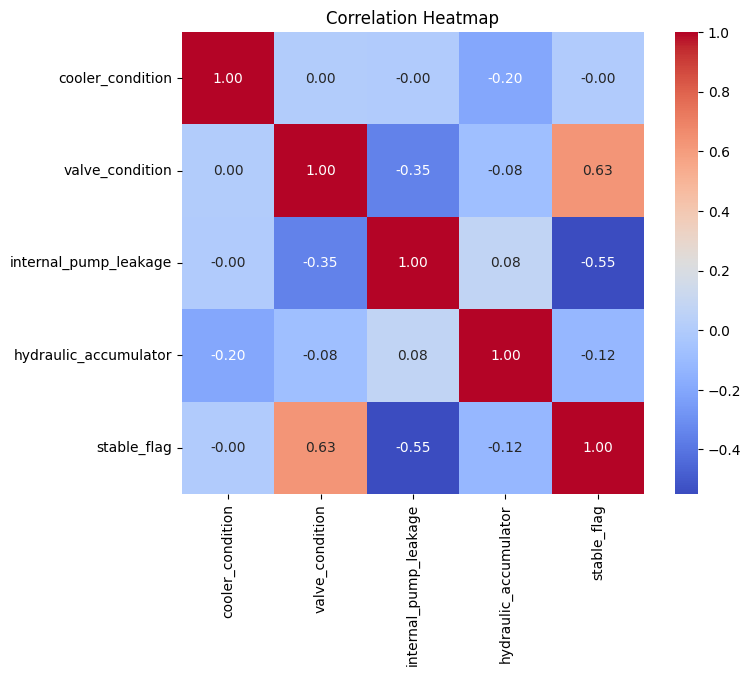

In [39]:
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title("Correlation Heatmap")
plt.show()

In [40]:
weights = correlation_matrix['stable_flag']

weights_dict = weights.to_dict() #convert to dictionary for easier handling

for feature, weight in weights_dict.items():
    print(f"{feature}: {weight}")

cooler_condition: -0.004105045484504893
valve_condition: 0.6294329131160301
internal_pump_leakage: -0.5496780139511884
hydraulic_accumulator: -0.12081669991835049
stable_flag: 1.0


Normalizing the weights to have sum equal to 1

In [41]:
total = sum(abs(w) for w in weights_dict.values())
normalized_weights = {k: abs(v) / total for k, v in weights_dict.items()}
normalized_weights

{'cooler_condition': 0.0017816785037618479,
 'valve_condition': 0.27318749453376323,
 'internal_pump_leakage': 0.23857214375432342,
 'hydraulic_accumulator': 0.05243706018666267,
 'stable_flag': 0.43402162302148894}

Υπολογίζουμε το maintenance_score με βάση τα παραπάνω weights

In [42]:
def compute_maintenance_score(row, weights):
    # Compute an initial score using the provided weights
    base_score = (row['cooler_condition'] * weights['cooler_condition'] +
                  row['valve_condition'] * weights['valve_condition'] +
                  row['internal_pump_leakage'] * weights['internal_pump_leakage'] +
                  row['hydraulic_accumulator'] * weights['hydraulic_accumulator'])

    # If stable_flag is 0 (machine is stable), reduce the score
    if row['stable_flag'] == 0:
        return base_score * (1 + weights['stable_flag'])  # Apply stability weight

    return base_score  # Return the raw score without capping at 1

training_table["maintenance_score"] = training_table.apply(lambda row: compute_maintenance_score(row, weights_dict), axis=1)
# Scale maintenance_score to minMax
min_max_scaler = MinMaxScaler()
training_table["maintenance_score"] = min_max_scaler.fit_transform(training_table[["maintenance_score"]])
training_table

,meanPS,stdPS,minPS,maxPS,rangePS,rmsPS,meanFS,stdFS,minFS,maxFS,...,minSE_ema,maxSE_ema,rangeSE_ema,rmsSE_ema,cooler_condition,valve_condition,internal_pump_leakage,hydraulic_accumulator,stable_flag,maintenance_score
0,-0.070639,-0.360957,0.144353,-1.897972,-4.929704,-0.103511,0.875728,0.261479,1.206382,-1.516235,...,0.0,-0.063981,-0.063981,0.456140,-0.902469,0.87141,-0.819277,1.387554,1,0.780412
1,-0.126748,-0.359408,0.096028,-1.904578,-4.805717,-0.155573,0.953815,-0.166577,1.653169,-1.496113,...,0.0,-0.012027,-0.012027,0.465906,-0.902469,0.87141,-0.819277,1.387554,1,0.780412
2,-0.188319,-0.355868,0.014818,-1.893104,-4.543691,-0.212142,0.928557,-0.087029,1.530521,-1.549772,...,0.0,0.045401,0.045401,0.482991,-0.902469,0.87141,-0.819277,1.387554,1,0.780412
3,-0.231262,-0.353987,-0.044231,-2.141165,-4.962767,-0.251566,0.882362,-0.053975,1.410064,-1.243469,...,0.0,0.089995,0.089995,0.507570,-0.902469,0.87141,-0.819277,1.387554,1,0.780412
4,-0.277941,-0.367171,-0.090698,-1.726746,-3.843164,-0.296599,0.810898,-0.086447,1.274276,-1.444690,...,0.0,0.129841,0.129841,0.507662,-0.902469,0.87141,-0.819277,1.387554,1,0.780412
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2200,0.983604,-0.348467,1.780136,1.665621,-1.185709,0.871977,0.770646,-0.219946,1.204192,1.381345,...,0.0,-0.423623,-0.423623,0.431455,1.386695,0.87141,-0.819277,-1.046703,0,0.997100
2201,0.980611,-0.346919,1.769412,1.613297,-1.279113,0.869081,0.767270,-0.192279,1.173530,1.580330,...,0.0,-0.421337,-0.421337,0.433398,1.386695,0.87141,-0.819277,-1.046703,0,0.997100
2202,0.975422,-0.350037,1.765981,1.648237,-1.186123,0.864302,0.766894,-0.267734,1.160389,1.032563,...,0.0,-0.409041,-0.409041,0.437521,1.386695,0.87141,-0.819277,-1.046703,0,0.997100
2203,0.982667,-0.350073,1.767411,1.664925,-1.150580,0.870597,0.761664,-0.202208,1.164769,1.511021,...,0.0,-0.413044,-0.413044,0.432365,1.386695,0.87141,-0.819277,-1.046703,0,0.997100


### Creating Failure Flag (failure_flag)
---
Indicator that shows where the system should break down

#### Based on the description of the dataset
---
- Sensor | Failure Threshold
- Cooler Condition (%) | ≤ 3
- Valve Condition (%) | ≤ 80
- Internal Pump Leakage | ≥ 2
- Accumulator Pressure (bar) | ≤ 100

In [43]:
def create_failure_flag(row):

  failure_flag = ((row["cooler_condition"] <= 3) |
  (row["valve_condition"] <= 70) |
  (row["internal_pump_leakage"] >= 2) |
  (row["hydraulic_accumulator"] <= 90)) and row["stable_flag"]

  return int(failure_flag)

In [44]:
training_table["failure_flag"] = training_table.apply(lambda row: create_failure_flag(row), axis = 1)
training_table

,meanPS,stdPS,minPS,maxPS,rangePS,rmsPS,meanFS,stdFS,minFS,maxFS,...,maxSE_ema,rangeSE_ema,rmsSE_ema,cooler_condition,valve_condition,internal_pump_leakage,hydraulic_accumulator,stable_flag,maintenance_score,failure_flag
0,-0.070639,-0.360957,0.144353,-1.897972,-4.929704,-0.103511,0.875728,0.261479,1.206382,-1.516235,...,-0.063981,-0.063981,0.456140,-0.902469,0.87141,-0.819277,1.387554,1,0.780412,1
1,-0.126748,-0.359408,0.096028,-1.904578,-4.805717,-0.155573,0.953815,-0.166577,1.653169,-1.496113,...,-0.012027,-0.012027,0.465906,-0.902469,0.87141,-0.819277,1.387554,1,0.780412,1
2,-0.188319,-0.355868,0.014818,-1.893104,-4.543691,-0.212142,0.928557,-0.087029,1.530521,-1.549772,...,0.045401,0.045401,0.482991,-0.902469,0.87141,-0.819277,1.387554,1,0.780412,1
3,-0.231262,-0.353987,-0.044231,-2.141165,-4.962767,-0.251566,0.882362,-0.053975,1.410064,-1.243469,...,0.089995,0.089995,0.507570,-0.902469,0.87141,-0.819277,1.387554,1,0.780412,1
4,-0.277941,-0.367171,-0.090698,-1.726746,-3.843164,-0.296599,0.810898,-0.086447,1.274276,-1.444690,...,0.129841,0.129841,0.507662,-0.902469,0.87141,-0.819277,1.387554,1,0.780412,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2200,0.983604,-0.348467,1.780136,1.665621,-1.185709,0.871977,0.770646,-0.219946,1.204192,1.381345,...,-0.423623,-0.423623,0.431455,1.386695,0.87141,-0.819277,-1.046703,0,0.997100,0
2201,0.980611,-0.346919,1.769412,1.613297,-1.279113,0.869081,0.767270,-0.192279,1.173530,1.580330,...,-0.421337,-0.421337,0.433398,1.386695,0.87141,-0.819277,-1.046703,0,0.997100,0
2202,0.975422,-0.350037,1.765981,1.648237,-1.186123,0.864302,0.766894,-0.267734,1.160389,1.032563,...,-0.409041,-0.409041,0.437521,1.386695,0.87141,-0.819277,-1.046703,0,0.997100,0
2203,0.982667,-0.350073,1.767411,1.664925,-1.150580,0.870597,0.761664,-0.202208,1.164769,1.511021,...,-0.413044,-0.413044,0.432365,1.386695,0.87141,-0.819277,-1.046703,0,0.997100,0


###Creating Remaining Useful Life (RUL)

In [45]:
# RUL = Time To Failure and we calculating it based on the failure_flag
def compute_ttf(failure_flags):
    ttf = np.zeros_like(failure_flags, dtype=int)
    next_failure = None
    for i in reversed(range(len(failure_flags))):
        if failure_flags[i]:
            next_failure = i
        ttf[i] = (next_failure - i) if next_failure is not None else len(failure_flags)
    return ttf

In [46]:
training_table["rul"] = compute_ttf(training_table["failure_flag"].values)
training_table

,meanPS,stdPS,minPS,maxPS,rangePS,rmsPS,meanFS,stdFS,minFS,maxFS,...,rangeSE_ema,rmsSE_ema,cooler_condition,valve_condition,internal_pump_leakage,hydraulic_accumulator,stable_flag,maintenance_score,failure_flag,rul
0,-0.070639,-0.360957,0.144353,-1.897972,-4.929704,-0.103511,0.875728,0.261479,1.206382,-1.516235,...,-0.063981,0.456140,-0.902469,0.87141,-0.819277,1.387554,1,0.780412,1,0
1,-0.126748,-0.359408,0.096028,-1.904578,-4.805717,-0.155573,0.953815,-0.166577,1.653169,-1.496113,...,-0.012027,0.465906,-0.902469,0.87141,-0.819277,1.387554,1,0.780412,1,0
2,-0.188319,-0.355868,0.014818,-1.893104,-4.543691,-0.212142,0.928557,-0.087029,1.530521,-1.549772,...,0.045401,0.482991,-0.902469,0.87141,-0.819277,1.387554,1,0.780412,1,0
3,-0.231262,-0.353987,-0.044231,-2.141165,-4.962767,-0.251566,0.882362,-0.053975,1.410064,-1.243469,...,0.089995,0.507570,-0.902469,0.87141,-0.819277,1.387554,1,0.780412,1,0
4,-0.277941,-0.367171,-0.090698,-1.726746,-3.843164,-0.296599,0.810898,-0.086447,1.274276,-1.444690,...,0.129841,0.507662,-0.902469,0.87141,-0.819277,1.387554,1,0.780412,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2200,0.983604,-0.348467,1.780136,1.665621,-1.185709,0.871977,0.770646,-0.219946,1.204192,1.381345,...,-0.423623,0.431455,1.386695,0.87141,-0.819277,-1.046703,0,0.997100,0,2205
2201,0.980611,-0.346919,1.769412,1.613297,-1.279113,0.869081,0.767270,-0.192279,1.173530,1.580330,...,-0.421337,0.433398,1.386695,0.87141,-0.819277,-1.046703,0,0.997100,0,2205
2202,0.975422,-0.350037,1.765981,1.648237,-1.186123,0.864302,0.766894,-0.267734,1.160389,1.032563,...,-0.409041,0.437521,1.386695,0.87141,-0.819277,-1.046703,0,0.997100,0,2205
2203,0.982667,-0.350073,1.767411,1.664925,-1.150580,0.870597,0.761664,-0.202208,1.164769,1.511021,...,-0.413044,0.432365,1.386695,0.87141,-0.819277,-1.046703,0,0.997100,0,2205


### Creating (multi-class) Health State Classification

- Health State Classes
  - Class 0 : Healthy
  - Class 1 : Degraded
  - Class 2 : Failing

In [47]:
# Health State Classification (multi-class)
def compute_health_state(rul_series):
    values = [0, 1, 2]  # 0: Healthy, 1: Degraded, 2: Failing
    return pd.cut(rul_series, bins=[-1, 10, 30, float('inf')], labels=[2,1,0], right=True).astype(int)

In [48]:
training_table["health_state"] = compute_health_state(training_table["rul"])
training_table.health_state.value_counts()

,count
health_state,
2,1106
1,700
0,399


### Creating Mode Classification (multi-label flag)


Explanation

In [49]:
# Failure Mode Classification (multi-label flags)
def compute_failure_modes(df):
    failure_modes = pd.DataFrame()
    failure_modes["cooler_failure"] = (df["cooler_condition"] <= 20).astype(int)
    failure_modes["valve_failure"] = (df["valve_condition"] <= 80).astype(int)
    failure_modes["pump_failure"] = (df["internal_pump_leakage"] >= 1).astype(int)
    failure_modes["hydraulic_failure"] = (df["hydraulic_accumulator"] <= 100).astype(int)
    return failure_modes

In [50]:
failure_modes_df = compute_failure_modes(training_table)
training_table = pd.concat([training_table, failure_modes_df], axis=1)
training_table

,meanPS,stdPS,minPS,maxPS,rangePS,rmsPS,meanFS,stdFS,minFS,maxFS,...,hydraulic_accumulator,stable_flag,maintenance_score,failure_flag,rul,health_state,cooler_failure,valve_failure,pump_failure,hydraulic_failure
0,-0.070639,-0.360957,0.144353,-1.897972,-4.929704,-0.103511,0.875728,0.261479,1.206382,-1.516235,...,1.387554,1,0.780412,1,0,2,1,1,0,1
1,-0.126748,-0.359408,0.096028,-1.904578,-4.805717,-0.155573,0.953815,-0.166577,1.653169,-1.496113,...,1.387554,1,0.780412,1,0,2,1,1,0,1
2,-0.188319,-0.355868,0.014818,-1.893104,-4.543691,-0.212142,0.928557,-0.087029,1.530521,-1.549772,...,1.387554,1,0.780412,1,0,2,1,1,0,1
3,-0.231262,-0.353987,-0.044231,-2.141165,-4.962767,-0.251566,0.882362,-0.053975,1.410064,-1.243469,...,1.387554,1,0.780412,1,0,2,1,1,0,1
4,-0.277941,-0.367171,-0.090698,-1.726746,-3.843164,-0.296599,0.810898,-0.086447,1.274276,-1.444690,...,1.387554,1,0.780412,1,0,2,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2200,0.983604,-0.348467,1.780136,1.665621,-1.185709,0.871977,0.770646,-0.219946,1.204192,1.381345,...,-1.046703,0,0.997100,0,2205,0,1,1,0,1
2201,0.980611,-0.346919,1.769412,1.613297,-1.279113,0.869081,0.767270,-0.192279,1.173530,1.580330,...,-1.046703,0,0.997100,0,2205,0,1,1,0,1
2202,0.975422,-0.350037,1.765981,1.648237,-1.186123,0.864302,0.766894,-0.267734,1.160389,1.032563,...,-1.046703,0,0.997100,0,2205,0,1,1,0,1
2203,0.982667,-0.350073,1.767411,1.664925,-1.150580,0.870597,0.761664,-0.202208,1.164769,1.511021,...,-1.046703,0,0.997100,0,2205,0,1,1,0,1


# Model training

**NOTE:** needs change to switch from classifiers to regressors and ultimately predict maintenance_score.

/*DONE*/

###Reviewing Dataset

In [51]:
training_table

,meanPS,stdPS,minPS,maxPS,rangePS,rmsPS,meanFS,stdFS,minFS,maxFS,...,hydraulic_accumulator,stable_flag,maintenance_score,failure_flag,rul,health_state,cooler_failure,valve_failure,pump_failure,hydraulic_failure
0,-0.070639,-0.360957,0.144353,-1.897972,-4.929704,-0.103511,0.875728,0.261479,1.206382,-1.516235,...,1.387554,1,0.780412,1,0,2,1,1,0,1
1,-0.126748,-0.359408,0.096028,-1.904578,-4.805717,-0.155573,0.953815,-0.166577,1.653169,-1.496113,...,1.387554,1,0.780412,1,0,2,1,1,0,1
2,-0.188319,-0.355868,0.014818,-1.893104,-4.543691,-0.212142,0.928557,-0.087029,1.530521,-1.549772,...,1.387554,1,0.780412,1,0,2,1,1,0,1
3,-0.231262,-0.353987,-0.044231,-2.141165,-4.962767,-0.251566,0.882362,-0.053975,1.410064,-1.243469,...,1.387554,1,0.780412,1,0,2,1,1,0,1
4,-0.277941,-0.367171,-0.090698,-1.726746,-3.843164,-0.296599,0.810898,-0.086447,1.274276,-1.444690,...,1.387554,1,0.780412,1,0,2,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2200,0.983604,-0.348467,1.780136,1.665621,-1.185709,0.871977,0.770646,-0.219946,1.204192,1.381345,...,-1.046703,0,0.997100,0,2205,0,1,1,0,1
2201,0.980611,-0.346919,1.769412,1.613297,-1.279113,0.869081,0.767270,-0.192279,1.173530,1.580330,...,-1.046703,0,0.997100,0,2205,0,1,1,0,1
2202,0.975422,-0.350037,1.765981,1.648237,-1.186123,0.864302,0.766894,-0.267734,1.160389,1.032563,...,-1.046703,0,0.997100,0,2205,0,1,1,0,1
2203,0.982667,-0.350073,1.767411,1.664925,-1.150580,0.870597,0.761664,-0.202208,1.164769,1.511021,...,-1.046703,0,0.997100,0,2205,0,1,1,0,1


In [52]:
list(training_table.columns)

['meanPS',
 'stdPS',
 'minPS',
 'maxPS',
 'rangePS',
 'rmsPS',
 'meanFS',
 'stdFS',
 'minFS',
 'maxFS',
 'rangeFS',
 'rmsFS',
 'meanTS',
 'stdTS',
 'minTS',
 'maxTS',
 'rangeTS',
 'rmsTS',
 'meanCE',
 'stdCE',
 'minCE',
 'maxCE',
 'rangeCE',
 'rmsCE',
 'meanCP',
 'stdCP',
 'minCP',
 'maxCP',
 'rangeCP',
 'rmsCP',
 'meanEPS1',
 'stdEPS1',
 'minEPS1',
 'maxEPS1',
 'rangeEPS1',
 'rmsEPS1',
 'meanVS1',
 'stdVS1',
 'minVS1',
 'maxVS1',
 'rangeVS1',
 'rmsVS1',
 'meanSE',
 'stdSE',
 'minSE',
 'maxSE',
 'rangeSE',
 'rmsSE',
 'PS10_10Hz',
 'PS110_50Hz',
 'PS20_10Hz',
 'PS210_50Hz',
 'PS30_10Hz',
 'PS310_50Hz',
 'PS40_10Hz',
 'PS410_50Hz',
 'PS50_10Hz',
 'PS510_50Hz',
 'PS60_10Hz',
 'PS610_50Hz',
 'EPS10_10Hz',
 'EPS110_50Hz',
 'FS10_10Hz',
 'FS20_10Hz',
 'TS10_10Hz',
 'TS20_10Hz',
 'TS30_10Hz',
 'TS40_10Hz',
 'VS10_10Hz',
 'CE0_10Hz',
 'CP0_10Hz',
 'SE0_10Hz',
 'PS1_peak1_freq',
 'PS1_peak1_mag',
 'PS1_peak2_freq',
 'PS1_peak2_mag',
 'PS1_peak3_freq',
 'PS1_peak3_mag',
 'PS2_peak1_freq',
 'PS2_

In [53]:
#i am placing maintenance_score last for easier handling later on the train test split
maintenance_col = training_table['maintenance_score']

training_table = training_table.drop(columns=['maintenance_score'])

training_table['maintenance_score'] = maintenance_col

Now we are going to check which features are more important at guessing maintenance score

In [54]:
X = training_table.drop(columns=['maintenance_score'])
y = training_table['maintenance_score']

In [55]:
from sklearn.model_selection import train_test_split

X_train1, X_test1, y_train1, y_test1 = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [56]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(random_state=42)
model.fit(X_train1, y_train1)


RandomForestRegressor(random_state=42)

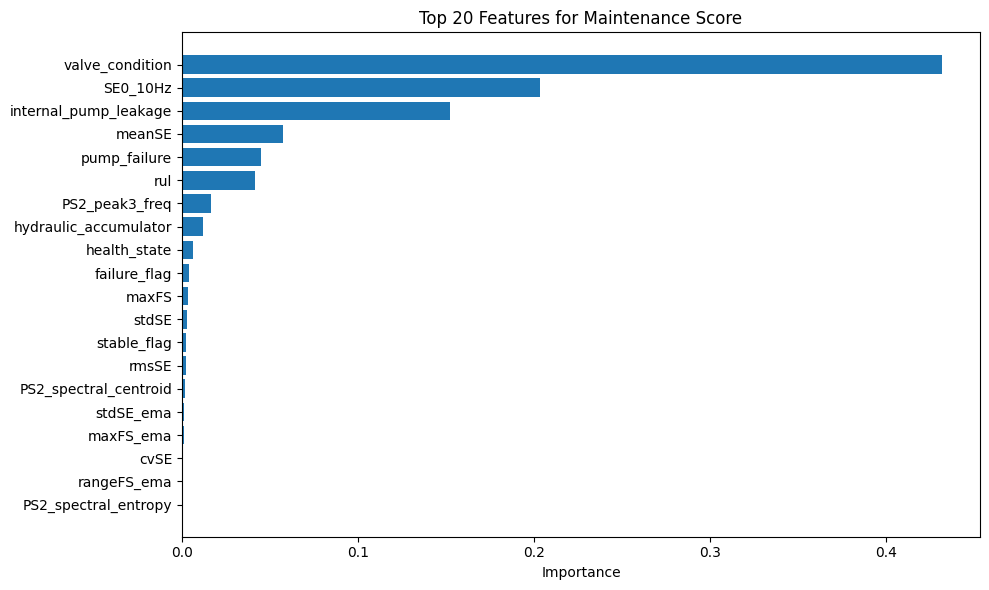

In [57]:
importances = model.feature_importances_
feature_names = X.columns
feat_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Visualizing
plt.figure(figsize=(10, 6))
plt.barh(feat_imp_df['Feature'][:20][::-1], feat_imp_df['Importance'][:20][::-1])
plt.xlabel('Importance')
plt.title('Top 20 Features for Maintenance Score')
plt.tight_layout()
plt.show()

### splitting

In [58]:
from sklearn.model_selection import train_test_split

top_features = feat_imp_df['Feature'].head(20) # Top features from feature importance

X_top = training_table[top_features]

y = training_table['maintenance_score']

X_train, X_test, y_train, y_test = train_test_split(X_top, y, test_size=0.2, random_state=42)

### fitting and testing models

Function to get the score of each model

In [59]:
def get_score(model, X_train, X_test ,y_train, y_test):
  model.fit(X_train, y_train)
  return model.score(X_test, y_test)

In [60]:
# importing the  models
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

rf_model = RandomForestRegressor(n_estimators=100)
svm_model = SVR()
knn_model = KNeighborsRegressor()

In [61]:
print("rf score:" + str(get_score(rf_model, X_train, X_test, y_train, y_test)))
print("svm score:" + str(get_score(svm_model, X_train, X_test, y_train, y_test)))
print("kneighbohrs score:" + str(get_score(knn_model, X_train, X_test, y_train, y_test)))

rf score:0.9994748260261456
svm score:0.821805971930817
kneighbohrs score:0.9791372556139573


I'm going to try to use kfold cross validation

In [62]:
from sklearn.model_selection import KFold, cross_val_score

kfold = KFold(n_splits=10, shuffle=True, random_state=42)

rf_scores = cross_val_score(rf_model, X_train, y_train, cv=kfold, scoring='r2')
svm_scores = cross_val_score(svm_model, X_train, y_train, cv=kfold, scoring='r2')
knn_scores = cross_val_score(knn_model, X_train, y_train, cv=kfold, scoring='r2')

In [63]:
rf_scores

array([0.99937657, 0.9992654 , 0.99723709, 0.99728915, 0.99931328,
       0.99851372, 0.99959813, 0.99970399, 0.99788339, 0.99874174])

In [64]:
svm_scores

array([0.80603458, 0.77110483, 0.75705454, 0.76933226, 0.68348224,
       0.80856683, 0.73677992, 0.79125405, 0.81429098, 0.69171585])

In [65]:
knn_scores

array([0.9765244 , 0.95677725, 0.97145342, 0.9636045 , 0.9112657 ,
       0.9713887 , 0.97302891, 0.97984475, 0.96508813, 0.95206871])

In [66]:
def get_av(score_list):
  av_score = np.median(score_list)
  return av_score

In [67]:
get_av(rf_scores) # average of rf

np.float64(0.999003572255795)

In [68]:
get_av(svm_scores) # average of svm

np.float64(0.7702185432809351)

In [69]:
get_av(knn_scores) # average of knn

np.float64(0.968238415843142)

As we see the rf model is the most accurate

### Deep Learning

In [71]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import mean_squared_error, r2_score

Scalling the data

In [92]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test) # no fit here because there will be data leakage

ReLU (Rectified Linear Unit) :
f(x) = max(0, x)

In [94]:
dl_model = Sequential()
dl_model.add(Dense(128, activation='relu', input_shape=(X_train.shape[1],)))
dl_model.add(Dense(64, activation='relu'))
dl_model.add(Dense(32, activation='relu'))
dl_model.add(Dense(1))


In [95]:
dl_model.compile(optimizer='adam', loss='mse', metrics=['mae']) #compiling

In [96]:
dl_model_fitted = dl_model.fit(X_train_scaled, y_train, validation_split=0.2, epochs=100, batch_size=16, verbose=1)

Epoch 1/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0513 - mae: 0.1424 - val_loss: 0.0046 - val_mae: 0.0483
Epoch 2/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0043 - mae: 0.0417 - val_loss: 0.0013 - val_mae: 0.0267
Epoch 3/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0011 - mae: 0.0233 - val_loss: 9.4543e-04 - val_mae: 0.0231
Epoch 4/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 9.8093e-04 - mae: 0.0228 - val_loss: 6.1215e-04 - val_mae: 0.0177
Epoch 5/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 6.8820e-04 - mae: 0.0187 - val_loss: 9.0344e-04 - val_mae: 0.0222
Epoch 6/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0015 - mae: 0.0209 - val_loss: 7.2281e-04 - val_mae: 0.0181
Epoch 7/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0056 - mae: 0.0229 - val_loss: 0.0012 - val_mae: 0.0264
Epoch 8/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0011 - mae: 0.0205 - val_loss: 6.6811e-04 - val_mae: 0.0183
Epoch 9/100
89/89 ━━━━━━━━━━━━━━━━━━

now we will track the loss

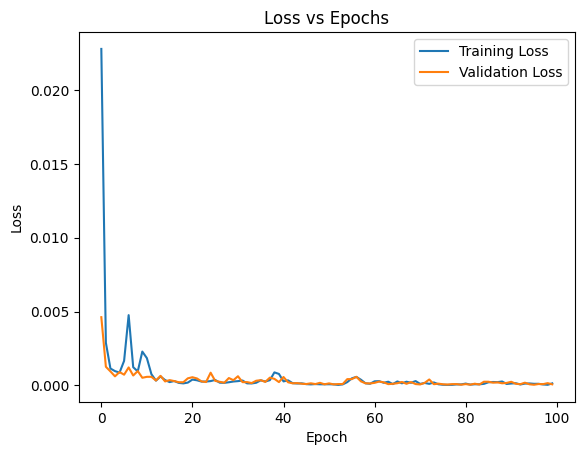

In [97]:
import matplotlib.pyplot as plt

plt.plot(dl_model_fitted.history['loss'], label='Training Loss')
plt.plot(dl_model_fitted.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Loss vs Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [98]:
dl_model.evaluate(X_test_scaled, y_test)

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 1.5528e-04 - mae: 0.0085


[0.000157829825184308, 0.008075248450040817]

Plot of the predictions vs real values

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step


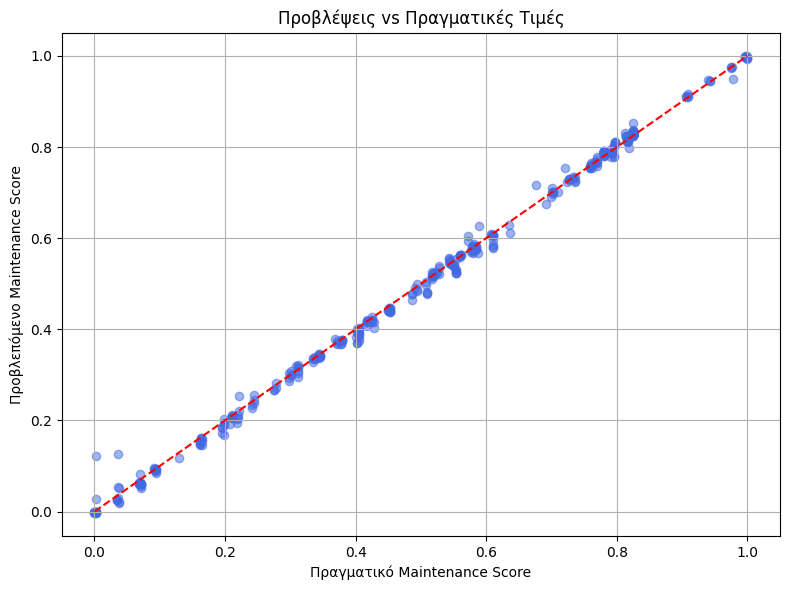

In [99]:
import matplotlib.pyplot as plt

y_pred = dl_model.predict(X_test_scaled) # predictions

# Graph
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5, color='royalblue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Πραγματικό Maintenance Score")
plt.ylabel("Προβλεπόμενο Maintenance Score")
plt.title("Προβλέψεις vs Πραγματικές Τιμές")
plt.grid(True)
plt.tight_layout()
plt.show()